<h1><center> Image Recognition Project</center></h1>

#### Name: Hugo Toth
#### E-mail: hu41go@gmail.com

## Introduction

The purpose of this task is to classify images using supervised machine learning. The data used are three sets of image URLs provided as text files: grass, sand and stairs. The images, having different resolutions and dimensions, were gathered from https://unsplash.com/. Thus, we will have 3 different classes, with one label per image.

We will create a training set by extracting several features, like first-order and GLCM texture features, from the images. This will be used to train various classifiers (Ridge Classifier, Random Forest, Multi-Layer Perceptron) to identify the correct image classes. For each classifier, multiple hyperparameter combinations will be tested in order to find the optimal configurations.

The final step involves estimating the performance of each classifier on unseen data with the help of nested cross-validation.

## Data preparation

Necessary preparations for the data include:
- importing all the packages needed for this notebook
- reading the URL's from the text files and importing the images
- croping and resizing the images into same size
- for GLCM and GLRLM, changing the images into grayscale and reducing the quantization level

In [1]:
import numpy as np
import cv2
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from skimage.feature import graycomatrix, graycoprops
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# Function to read image URLs from text file
# Returns a list containing each image's URL
def read_image_urls(filename):
    with open(filename, 'r') as file:
        return [line.strip() for line in file.readlines()]

# Load the URLs from the 3 text files
grass_urls = read_image_urls("grass.txt")
sand_urls = read_image_urls("sand.txt")
stairs_urls = read_image_urls("stairs.txt")

# Function to fetch image data from its URL
# Store it as PIL image
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

# Download images in separate lists
grass_images = [download_image(url) for url in grass_urls]
sand_images = [download_image(url) for url in sand_urls]
stairs_images = [download_image(url) for url in stairs_urls]

In [3]:
# Define the target size
target_size = (256, 256)

# Function to resize and crop images
def preprocess_image(img, target_size):
    img = img.convert("RGB")  # Ensure image is in RGB mode
    img = img.resize(target_size, Image.LANCZOS)  # Resize to same target size
    return np.array(img)  # Convert to NumPy array

# Apply preprocessing to all image lists
grass_images_resized = [preprocess_image(img, target_size) for img in grass_images]
sand_images_resized = [preprocess_image(img, target_size) for img in sand_images]
stairs_images_resized = [preprocess_image(img, target_size) for img in stairs_images]

In [4]:
# Function to change image to grayscale and reduce quantization levels
def quantize_image(img, levels=8):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    quantized = np.floor(gray / (256 // levels))  # Reduce to 8 levels, pixel values [0-7]
    return quantized.astype(np.uint8)  # 8-bit unsigned integers

# Apply grayscale convertion and quantization to all images
grass_images_gray = [quantize_image(img) for img in grass_images_resized]
sand_images_gray = [quantize_image(img) for img in sand_images_resized]
stairs_images_gray = [quantize_image(img) for img in stairs_images_resized]

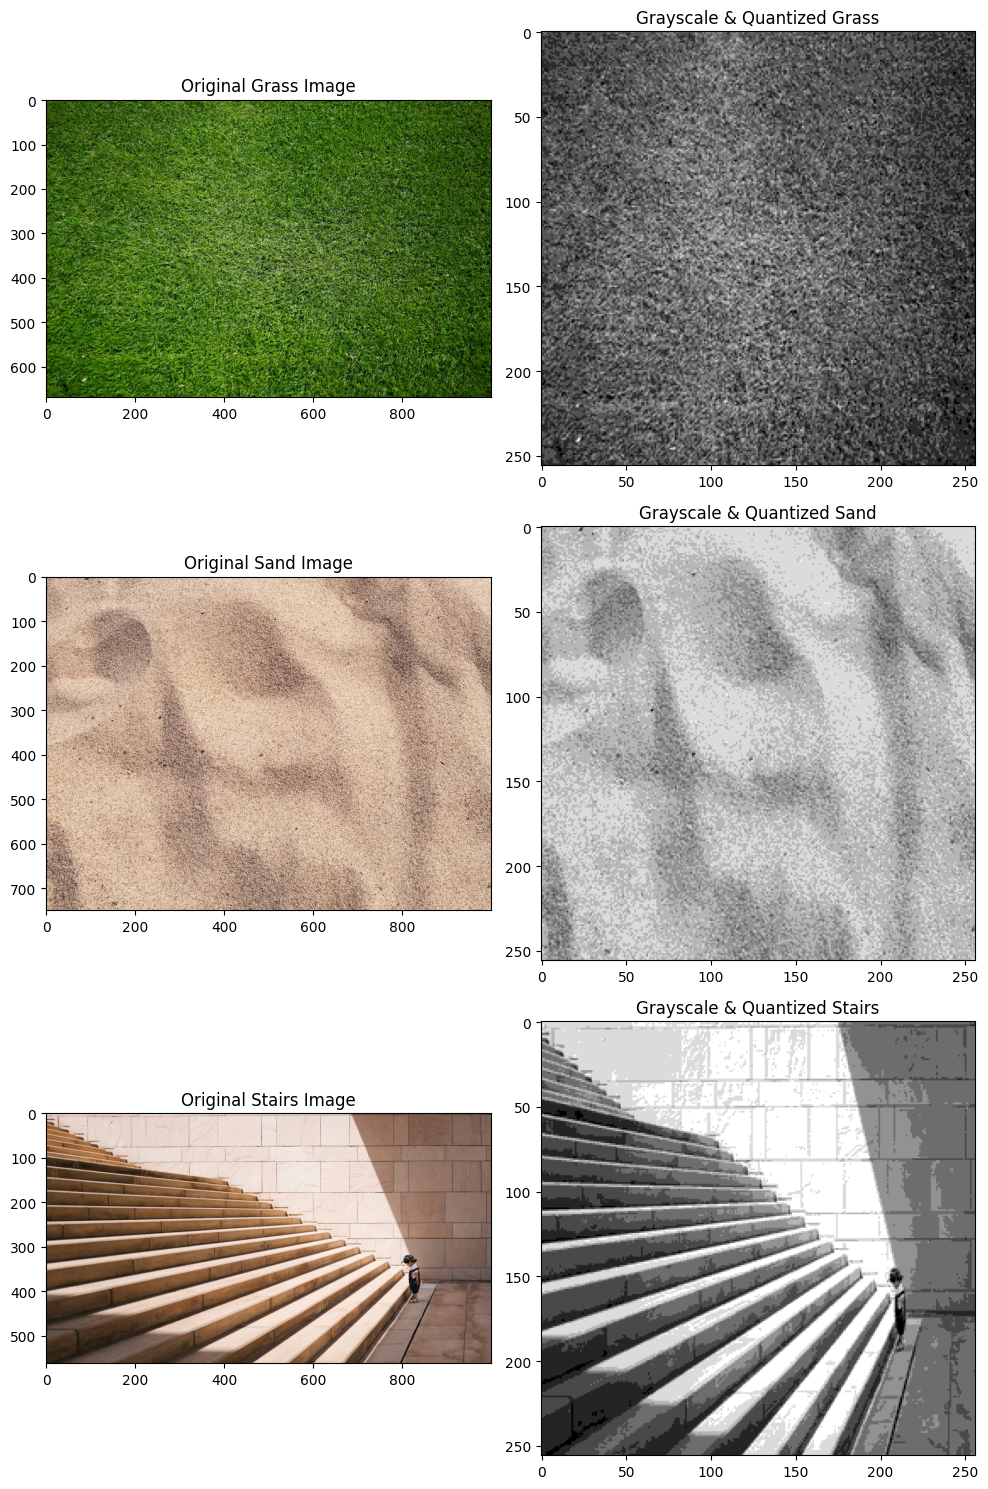

In [5]:
# Plot samples of original and processed images
# Create a figure to display images for grass, sand, and stairs
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# Titles for each row
categories = ["Grass", "Sand", "Stairs"]

# Lists of images from every group
original_images = [grass_images[0], sand_images[0], stairs_images[0]]
processed_images = [grass_images_gray[0], sand_images_gray[0], stairs_images_gray[0]]

# Loop through the three categories and display images on every row
for i in range(3):
    # Original image - RGB (left column)
    axes[i, 0].imshow(original_images[i])
    axes[i, 0].set_title(f"Original {categories[i]} Image")

    # Processed grayscale and quantized image (right column)
    axes[i, 1].imshow(processed_images[i], cmap='gray')
    axes[i, 1].set_title(f"Grayscale & Quantized {categories[i]}")

# Adjust  to avoid overlaps layout and show plot
plt.tight_layout()
plt.show()

## Feature extraction

### First order texture measures (6 features)

- We will calculate the below mentioned color features for each image:
    - Mean for each RGB color channel
    - Variance for each RGB color channel

In [6]:
# Function to compute mean and variance for RGB channels of an image
def compute_first_order_features(image):
    # Split and extract the red, green and blue channels
    r_channel, g_channel, b_channel = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    
    # Compute mean for each channel
    mean_r = np.mean(r_channel)
    mean_g = np.mean(g_channel)
    mean_b = np.mean(b_channel)
    
    # Compute variance for each channel
    var_r = np.var(r_channel)
    var_g = np.var(g_channel)
    var_b = np.var(b_channel)
    
    return [mean_r, mean_g, mean_b, var_r, var_g, var_b]

In [7]:
# Compute the 6 first-order features for all images of the dataset
# Store the results in lists
grass_rgb_features = [compute_first_order_features(img) for img in grass_images_resized]
sand_rgb_features = [compute_first_order_features(img) for img in sand_images_resized]
stairs_rgb_features = [compute_first_order_features(img) for img in stairs_images_resized]

# Print sample image's mean and variance features (one from each category)
print("Grass Image 1 RGB Features:", grass_rgb_features[0])
print("Sand Image 1 RGB Features:", sand_rgb_features[0])
print("Stairs Image 1 RGB Features:", stairs_rgb_features[0])

Grass Image 1 RGB Features: [65.30924987792969, 102.83030700683594, 27.018692016601562, 613.5586156116333, 746.5361914706882, 344.9922806133982]
Sand Image 1 RGB Features: [197.81297302246094, 168.94610595703125, 146.89585876464844, 527.7779939321335, 561.3695624731481, 471.35544183454476]
Stairs Image 1 RGB Features: [163.52578735351562, 136.87704467773438, 119.7509765625, 3841.7283084010705, 4234.222308746539, 4837.712370872498]


### Second order texture measures (4 features)

- Gray-Level-Co-Occurrence (GLCM) features:
    - For each image, we will:
        - calculate the GLC matrix
        - calculate the "correlation" feature using the acquired GLC matrix 
            - in horizontal and vertical directions for two reference pixel distances

In [8]:
# Define function to compute Gray-Level-Co-Occurrence features for given grayscale image
# distances: List of distances for reference pixels
# angles: List of angles (0° for horizontal, 90° for vertical)

def compute_glcm_features(image, distances=[1, 3], angles=[0, np.pi/2]):
    # Calculate GLC matrix
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=8, symmetric=True, normed=True)
    
    # Extract the 4 correlation features
    corr_features = []
    for d in range(len(distances)):
        for a in range(len(angles)):
            corr = graycoprops(glcm, 'correlation')[d, a]
            corr_features.append(corr)
    
    return corr_features

I decided on 1 and 3 pixels as the reference distances to compute texture relationships. The 1-pixel distance captures fine details and local variations in the image. Moving beyond immediate neighbors, the 3-pixel distance helps detect larger structured patterns, that may not be visible at distance 1. Overall, this choice provides a good balance for this dataset, which contains images with both rough and silkier textures. 

In [9]:
# Compute GLCM features for all images
grass_glcm_features = [compute_glcm_features(img) for img in grass_images_gray]
sand_glcm_features = [compute_glcm_features(img) for img in sand_images_gray]
stairs_glcm_features = [compute_glcm_features(img) for img in stairs_images_gray]

# Print sample image's correlation features (one from each category)
print("Grass Image 1 GLCM Features:", grass_glcm_features[0])
print("Sand Image 1 GLCM Features:", sand_glcm_features[0])
print("Stairs Image 1 GLCM Features:", stairs_glcm_features[0])

Grass Image 1 GLCM Features: [0.45917572193346917, 0.4544050828329639, 0.2970841022148575, 0.2787158299236556]
Sand Image 1 GLCM Features: [0.647839960615851, 0.6455700278076626, 0.5677366362852732, 0.5870331034215852]
Stairs Image 1 GLCM Features: [0.9597757098918162, 0.9173389225962343, 0.8652353004407592, 0.7564005834764436]


Gather your features into an input array X, and the image classes into an output array y. Standardize the feature values in X.

In [10]:
# Combine first-order (RGB) and second-order (GLCM) features for each image
grass_features = [rgb + glcm for rgb, glcm in zip(grass_rgb_features, grass_glcm_features)]
sand_features = [rgb + glcm for rgb, glcm in zip(sand_rgb_features, sand_glcm_features)]
stairs_features = [rgb + glcm for rgb, glcm in zip(stairs_rgb_features, stairs_glcm_features)]

# Concatenate feature lists for the 3 categories
# Convert to NumPy array
X = np.array(grass_features + sand_features + stairs_features)

# Create labels for image classes: 0 = Grass, 1 = Sand, 2 = Stairs
y = np.array([0] * len(grass_features) + [1] * len(sand_features) + [2] * len(stairs_features))

# Print shape of X and y to ensure it is accurate
print("Feature Matrix Shape (X):", X.shape)  # Should be 10 features
print("Labels Shape (y):", y.shape)

Feature Matrix Shape (X): (185, 10)
Labels Shape (y): (185,)


In [11]:
# Standardize the feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Print first few rows of standardized feature values
print("Standardized Feature Matrix:\n", X_scaled[:5])

Standardized Feature Matrix:
 [[-1.24298019 -0.59880318 -1.50958812 -1.03592451 -0.93371671 -0.88151889
  -3.06289524 -2.94261059 -2.35181129 -2.12232556]
 [-0.09663386  0.33919668  0.48118395  0.98141756  0.68511557  1.18720959
   0.6634597   0.68375821  0.85377596  0.88299486]
 [-2.0214826  -0.92110943 -1.71773259 -1.17693574  0.32310437 -0.90670608
  -1.49251728 -1.16258578 -2.80150495 -2.26939733]
 [-0.49307826 -0.2153374  -1.59635453 -0.82052781 -0.68090237 -0.81800771
  -1.65276633 -0.73612488 -1.75351885 -1.16261087]
 [-0.34682369  0.63281264 -1.26165004 -0.15626251 -0.43425246 -0.42804881
   0.04396335  0.64472061 -0.09775793  0.66960359]]


## Feature relationships

Next, we will make a few illustrations of feature relationships and discuss the results.

### Pairplot

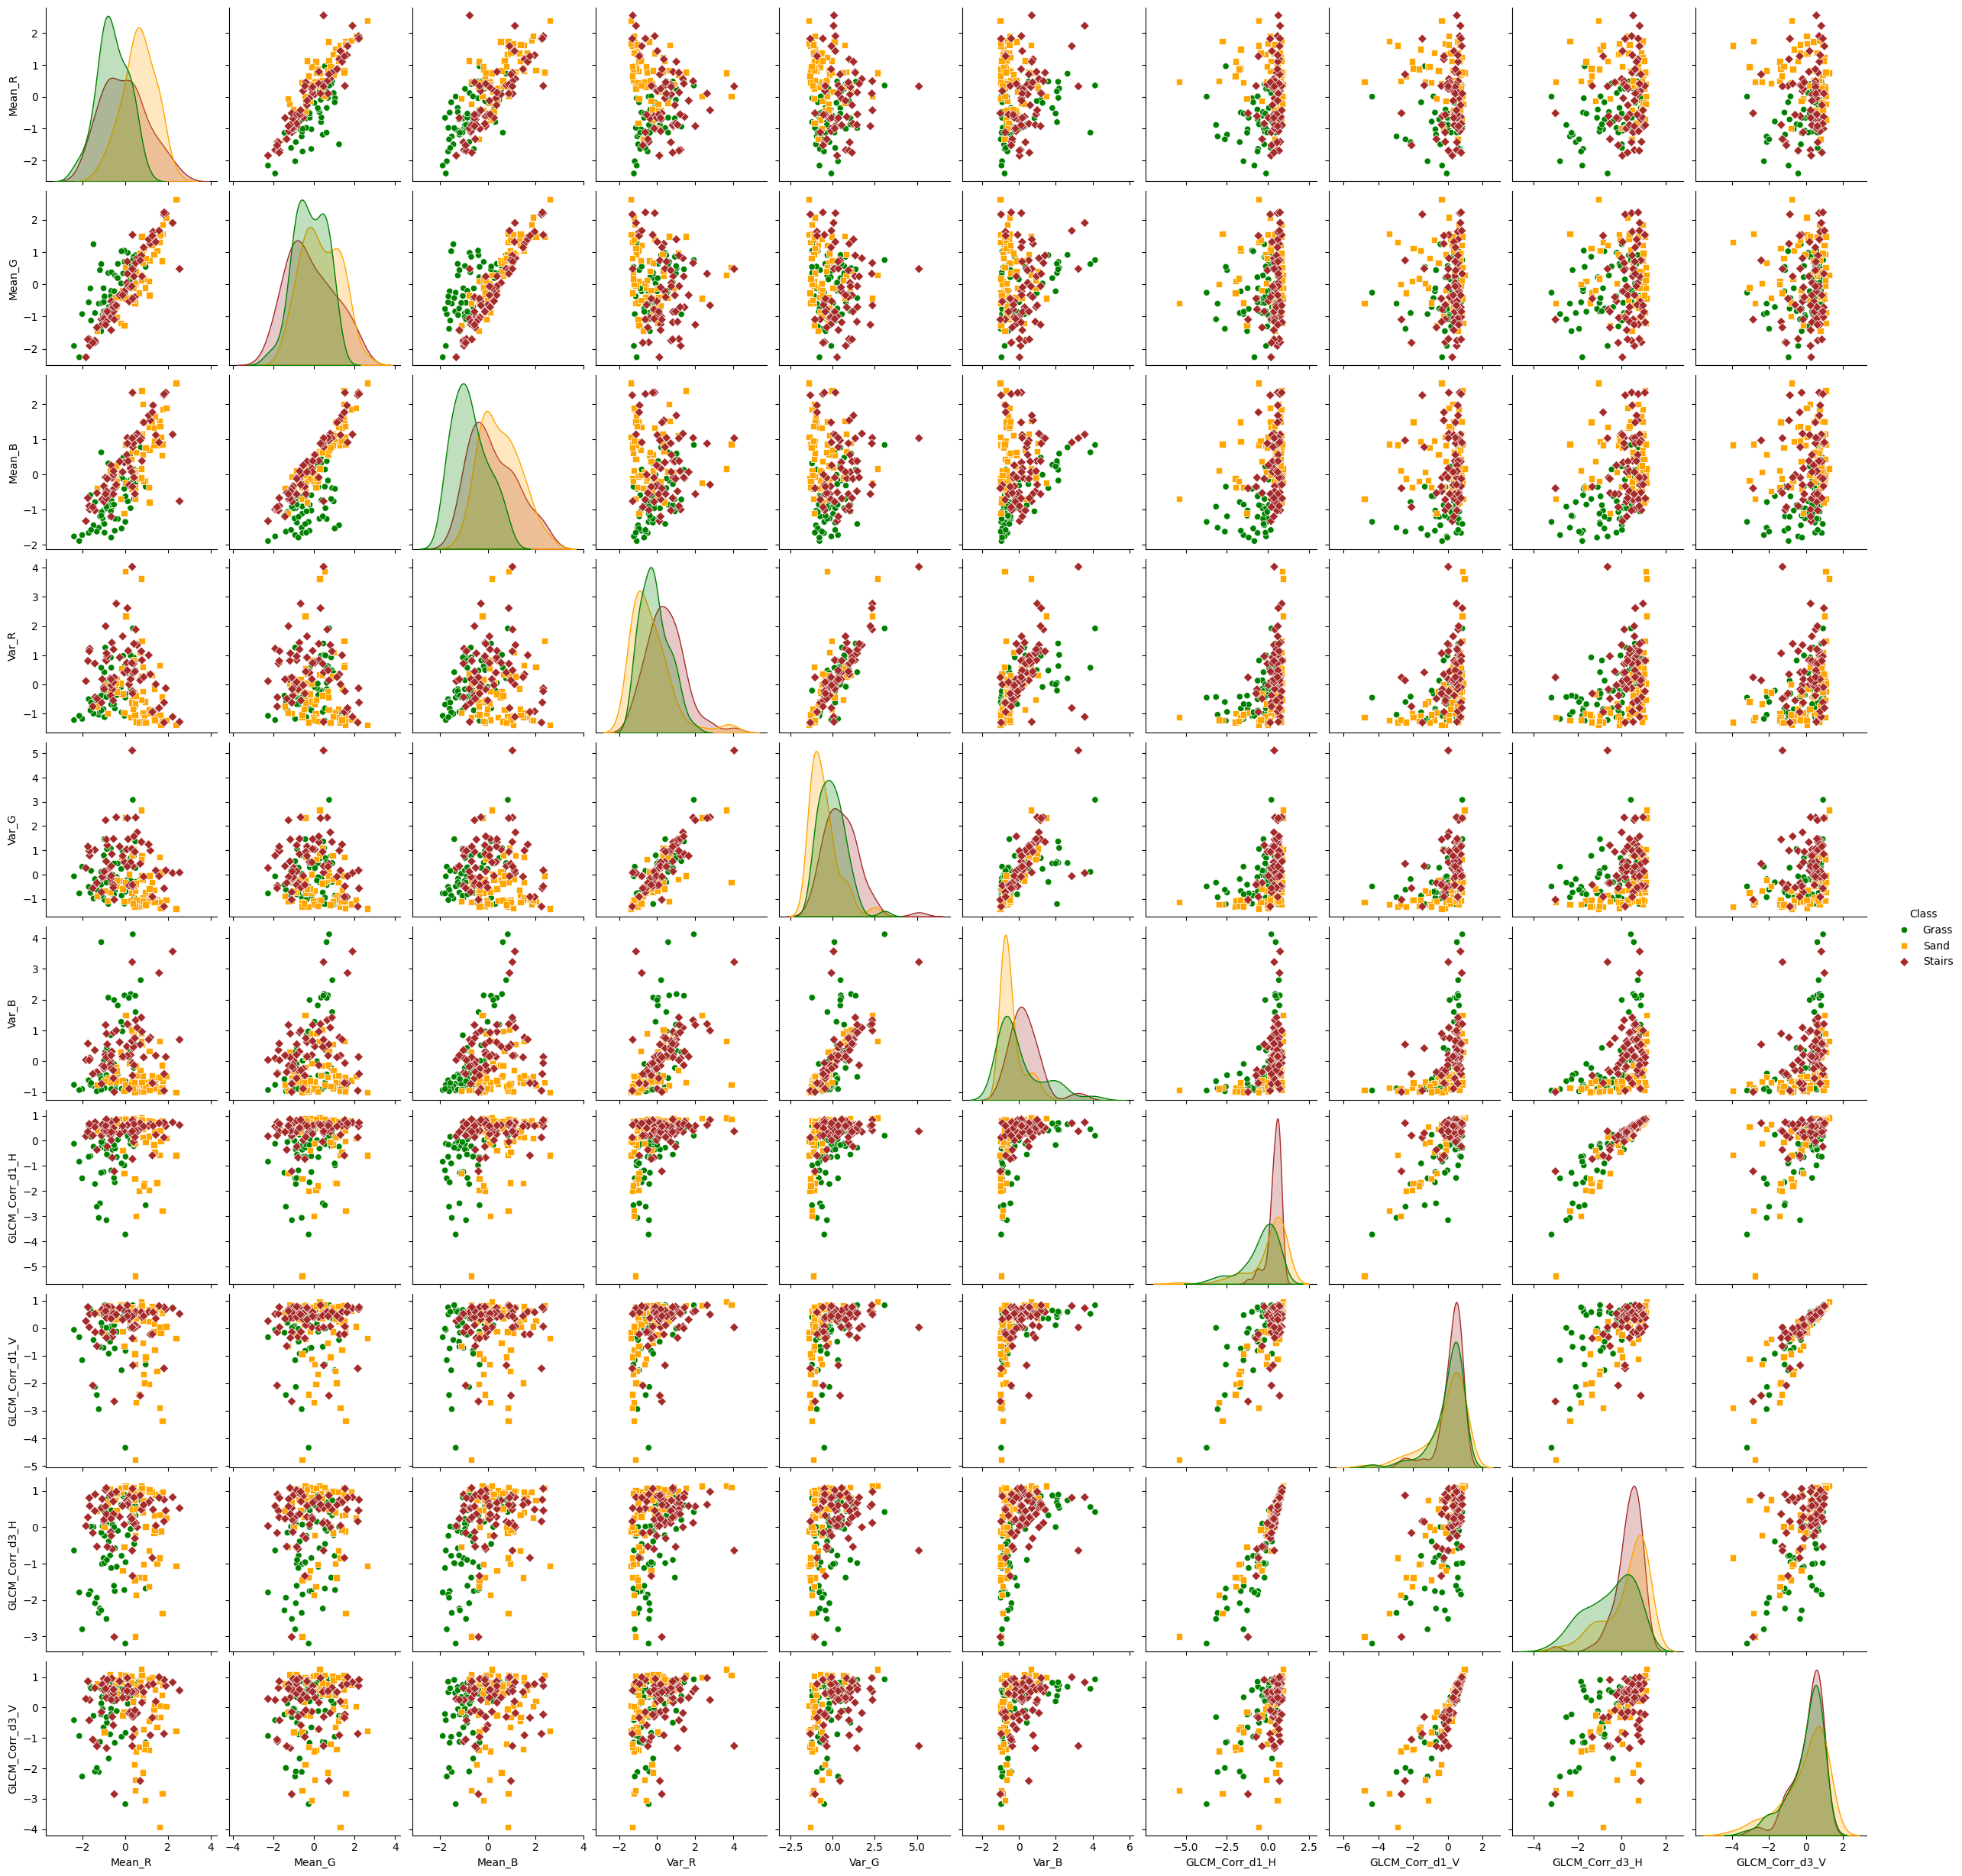

In [12]:
# Convert feature matrix to a DataFrame for illustrations
feature_names = [
    "Mean_R", "Mean_G", "Mean_B", 
    "Var_R", "Var_G", "Var_B", 
    "GLCM_Corr_d1_H", "GLCM_Corr_d1_V", "GLCM_Corr_d3_H", "GLCM_Corr_d3_V"
]

df = pd.DataFrame(X_scaled, columns=feature_names)
df["Class"] = y  # Add class labels

# Map class labels to the names of the categories
class_labels = {0: "Grass", 1: "Sand", 2: "Stairs"}
df["Class"] = df["Class"].map(class_labels)

# Create pairplot
sns.pairplot(df, hue="Class", palette={"Grass": "green", "Sand": "orange", "Stairs": "brown"}, markers=["o", "s", "D"])

plt.show()

A few feature pairs present roughly linear dependencies. The strongest positive correlations are shown between RGB mean values, since colors in an image often tend to be balanced. This can be seen in the plots 'Mean_Red' vs. 'Mean_Green', or 'Mean_Green' vs. 'Mean_Blue'. There is also moderate dependency between some GLCM Correlation Features in the horizontal and vertical directions. For example, 'GLCM_Corr_d1_H' and 'GLCM_Corr_d3_H', as well as 'GLCM_Corr_d1_V' and 'GLCM_Corr_d3_V' have a linear relationship (although more scattered), because they measure texture at different scales.

### Histograms

- We will plot a histogram for each Z-scored feature (all the image classes in the same figure; using a different color for each) to find out which features may have some discriminative power over image classes.

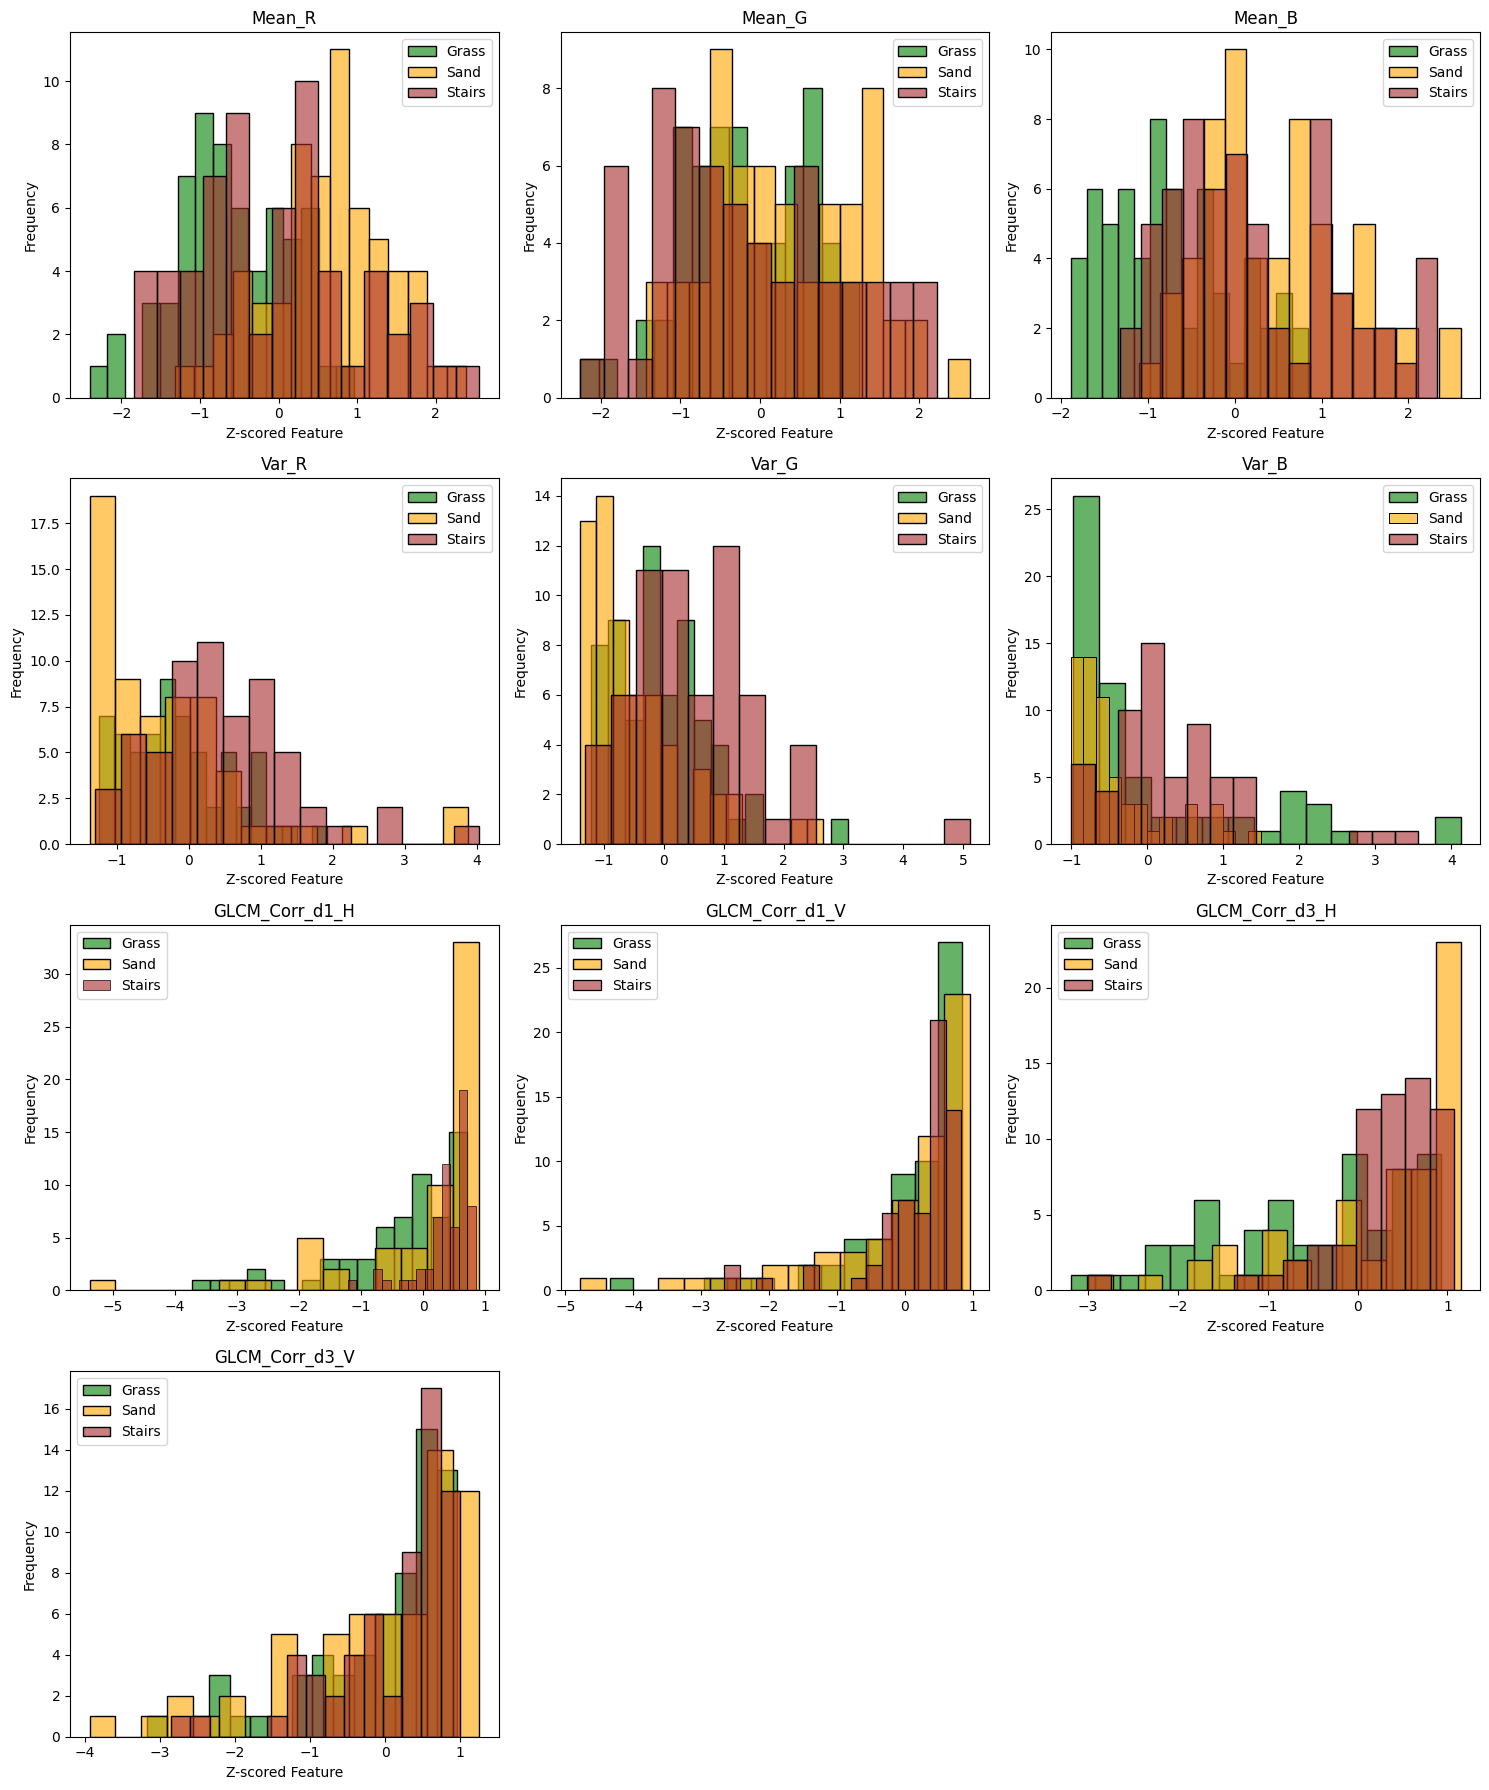

In [13]:
# Define colors for classes
colors = ["green", "orange", "brown"]

# Create histograms for each Z-scored feature
plt.figure(figsize=(15, 18))
for i in range(10):
    plt.subplot(4, 3, i + 1)  # Arrange in grid (4 rows, 3 cols)
    
    # Plot histogram for each image class
    for class_idx, class_name in class_labels.items():
        sns.histplot(X_scaled[y == class_idx, i], label=class_name, color=colors[class_idx], bins=15, alpha=0.6)
    
    plt.title(feature_names[i])
    plt.xlabel("Z-scored Feature")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()

By analyzing the histograms, we can observe that some features may have discriminative power over image classes. The distinct color tones are reflected in the RGB mean features: sand has a higher average red mean (Mean_R); grass has a significantly lower blue means (Mean_B) than stairs or sand. Regarding the variance features, sand images present lower variance in the red and green color channels (indicating a smoother texture), while grass images have very low variance in the blue channel (Var_B). The GLCM correlation features for the horizontal direction (especially GLCM_corr_d1_H) also seem to separate the sand class well.  

### PCA

- We will plot the image classes using different colors to see if there are any clusters in PCA.

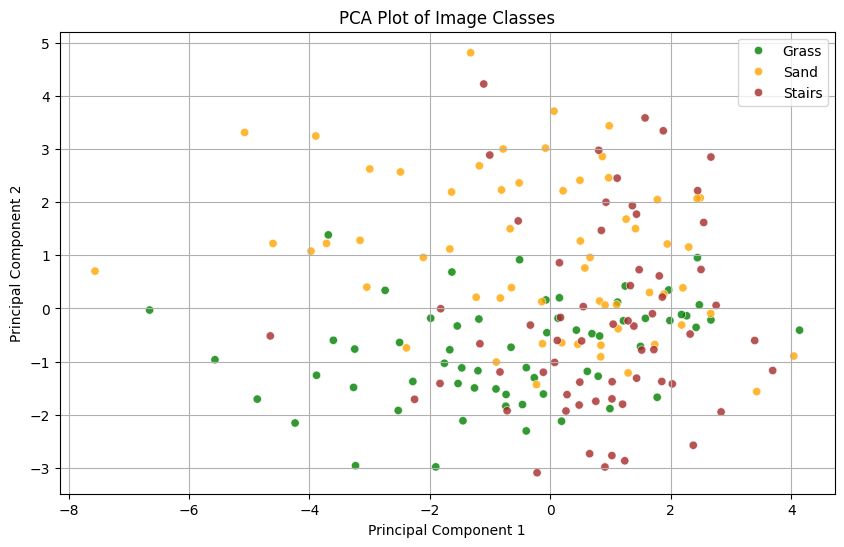

In [14]:
# Apply PCA to reduce from 10D to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert to DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Class"] = y
df_pca["Class"] = df_pca["Class"].map(class_labels)  # Map 0, 1, 2 to "Grass", "Sand", "Stairs"

# Scatter plot of PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Class", palette={"Grass": "green", "Sand": "orange", "Stairs": "brown"}, alpha=0.8)

plt.title("PCA Plot of Image Classes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

The PCA visualization does not exactly reveal distinct clusters. Classification of the image types may turn out more challenging (more advanced features/methods could be needed) because of the overlapping areas seen in the plot. 

## Building classifiers and selecting the best hyperparameters with cross validation

Now, we will perform model selection for each classifier, using 5-fold stratified cross validation (*StratifiedKFold* and *GridSearchCV* from sklearn) and the following hyperparameters:

##### Ridge Classifier:
    - strength of the regularization term: alpha = [0.001, 0.01, 0.1, 1.0]

##### Random Forest:
    - n_estimators: from 100 to 300 with 50 steps
    - max_features = ['sqrt', 'log2', None]
    - whether to use bootstrap or not 
    
##### MLP:
    - one hidden layer
    - number of neurons in the hidden layer: from 15 to 40 in 5 neuron steps
    - activation function: hyperbolic tanh function and rectified linear unit function
    - solver: stochastic gradient descent and adam
    - validation_fraction: 0.1 and 0.3
    - strength of the L2 regularization term: alpha = [0.01, 0.1, 1]

For each classifier, it is important to report:
- the selected combination of hyperparameters
- the accuracy value for each hyperparameter combination

For Random Forest model, we will also report the importance of each feature to discover which features are the most important.

In [15]:
# Define 5-fold stratified cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)

best_models = {}
results = {}

# Hyperparameters for Ridge Classifier
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1.0]}

# Ridge Classifier
ridge_clf = GridSearchCV(RidgeClassifier(), ridge_params, cv=cv, scoring='accuracy', n_jobs=-1)
ridge_clf.fit(X_scaled, y)

# Store results
best_models['Ridge'] = ridge_clf.best_params_
results['Ridge'] = pd.DataFrame(ridge_clf.cv_results_)

In [16]:
# Hyperparameters for Random Forest
rf_params = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Random Forest Classifier
rf_clf = GridSearchCV(RandomForestClassifier(random_state=2025), rf_params, cv=cv, scoring='accuracy', n_jobs=-1)
rf_clf.fit(X_scaled, y)

# Store results
best_models['RandomForest'] = rf_clf.best_params_
results['RandomForest'] = pd.DataFrame(rf_clf.cv_results_)

In [17]:
# Hyperparameters for MLP
mlp_params = {
    'hidden_layer_sizes': [(i,) for i in range(15, 45, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.01, 0.1, 1],
    'validation_fraction': [0.1, 0.3]
}

# MLP Classifier
mlp_clf = GridSearchCV(MLPClassifier(max_iter=1500, random_state=2025), mlp_params, cv=cv, scoring='accuracy', n_jobs=-1)
mlp_clf.fit(X_scaled, y)

# Store results
best_models['MLP'] = mlp_clf.best_params_
results['MLP'] = pd.DataFrame(mlp_clf.cv_results_)

In [18]:
# Display the best parameters for each classifier
for model_name, best_model in best_models.items():
    print(f"\nBest parameters for {model_name}: {best_model}")

# Print accuracy value for each hyperparameter combination
for model_name, df_results in results.items():
    print(f"\nHyperparameter performance for {model_name}:")
    print(df_results[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).to_string(index=False))


Best parameters for Ridge: {'alpha': 0.001}

Best parameters for RandomForest: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}

Best parameters for MLP: {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (30,), 'solver': 'adam', 'validation_fraction': 0.1}

Hyperparameter performance for Ridge:
          params  mean_test_score
{'alpha': 0.001}         0.816216
 {'alpha': 0.01}         0.816216
  {'alpha': 0.1}         0.816216
  {'alpha': 1.0}         0.810811

Hyperparameter performance for RandomForest:
                                                           params  mean_test_score
 {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}         0.767568
 {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 100}         0.767568
 {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 300}         0.762162
 {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 300}         0.762162
   {'bootstrap': True, 'max_features': None, 'n_e

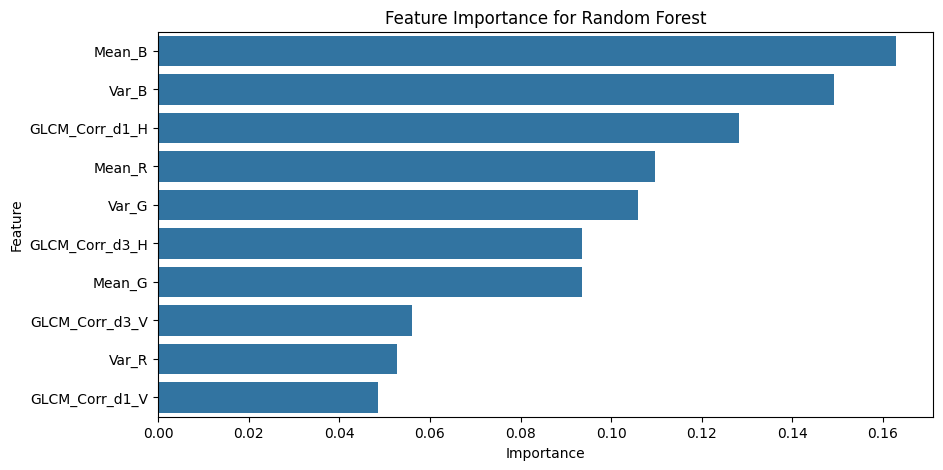


 Features ordered by importance:


Feature  Importance
2          Mean_B    0.162916
5           Var_B    0.149250
6  GLCM_Corr_d1_H    0.128102
0          Mean_R    0.109576
4           Var_G    0.105909
8  GLCM_Corr_d3_H    0.093632
1          Mean_G    0.093556
9  GLCM_Corr_d3_V    0.056005
3           Var_R    0.052624
7  GLCM_Corr_d1_V    0.048430

In [19]:
# Get feature importances from the best Random Forest model
feature_importances = rf_clf.best_estimator_.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance for RF
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance for Random Forest")
plt.show()

# Print top features
print("\n Features ordered by importance:")
display(feature_importance_df)

The three most important features for the Random Forest model, based on the scores, seem to be 'Mean_B', 'Var_B', 'GLCM_Corr_d1_H'. As highlighted in the data exploration part, the histograms for the mean and variance features of the blue color channel indicated a visible separation of the grass images from the other classes. In addition, the GLCM correlation feature in the horizontal direction (at distance 1) showed a distinct distribution for the sand images comparatively.

## Estimating the performance of the models with nested cross-validation

Lastly, we will estimate the performance of each model using nested cross validation. <br>
We will use 4-fold Stratified Kfold cross-validation and the same parameter ranges as earlier for the inner loop. <br>
For the outer loop we will use 5-fold Stratified Kfold cross-validation.

For each classifier we will: 
- Ridge Classifier
- Random Forest
- MLP

    Report the selected combination of the hyperparameters and the accuracy value for the best hyperparameter combination. <br> 
    Create a confusion matrix of the results. <br>
    Calculate the mean accuracy of the outer rounds.

In [20]:
# Define nested cross-validation loops
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=2025)

# Parameter grids already defined

# Store models
models = {
    "Ridge": (RidgeClassifier(), ridge_params),
    "RandomForest": (RandomForestClassifier(random_state=2025), rf_params),
    "MLP": (MLPClassifier(max_iter=2000, random_state=2025), mlp_params)
}

outer_scores = {}  # Store mean accuracy per model
conf_matrices = {}  # Store confusion matrices

In [21]:
# Perform Nested Cross-Validation
for model_name, (model, param_grid) in models.items():
    print(f"\nTraining {model_name} with Nested Cross-Validation...")

    # Store accuracy scores and best hyperparameters per fold
    outer_fold_accuracies = []
    best_params_list = []
    best_acc_list = []
    y_true_all, y_pred_all = [], []

    # Outer CV loop
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Inner CV Grid Search
        grid_search = GridSearchCV(model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get the best model, parameters and accuracy for this fold
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_acc = grid_search.best_score_  # Best accuracy from inner CV

        # Evaluate best model on the outer test set
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        
        # Store results
        best_params_list.append(best_params)
        best_acc_list.append(best_acc)  # Inner loop best accuracy
        outer_fold_accuracies.append(acc)  # Outer loop accuracy

        # Collect predictions for confusion matrix
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

    # Store mean accuracy and confusion matrix for this model
    outer_scores[model_name] = np.mean(outer_fold_accuracies)
    conf_matrices[model_name] = confusion_matrix(y_true_all, y_pred_all)

    # Print results
    print("Best Hyperparameters per Fold:")
    for i in range(outer_cv.n_splits):
        print(f"Fold {i+1}: {best_params_list[i]} → Best Inner CV Accuracy: {best_acc_list[i]:.4f}")
    
    print(f"\nMean Outer Loop Accuracy for {model_name}: {outer_scores[model_name]:.4f}")    


Training Ridge with Nested Cross-Validation...
Best Hyperparameters per Fold:
Fold 1: {'alpha': 1.0} → Best Inner CV Accuracy: 0.7838
Fold 2: {'alpha': 1.0} → Best Inner CV Accuracy: 0.8176
Fold 3: {'alpha': 1.0} → Best Inner CV Accuracy: 0.7500
Fold 4: {'alpha': 0.001} → Best Inner CV Accuracy: 0.8243
Fold 5: {'alpha': 0.001} → Best Inner CV Accuracy: 0.7568

Mean Outer Loop Accuracy for Ridge: 0.8108

Training RandomForest with Nested Cross-Validation...
Best Hyperparameters per Fold:
Fold 1: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 150} → Best Inner CV Accuracy: 0.7432
Fold 2: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100} → Best Inner CV Accuracy: 0.7365
Fold 3: {'bootstrap': True, 'max_features': None, 'n_estimators': 200} → Best Inner CV Accuracy: 0.7838
Fold 4: {'bootstrap': False, 'max_features': 'sqrt', 'n_estimators': 250} → Best Inner CV Accuracy: 0.7770
Fold 5: {'bootstrap': False, 'max_features': 'sqrt', 'n_estimators': 200} → Best Inn

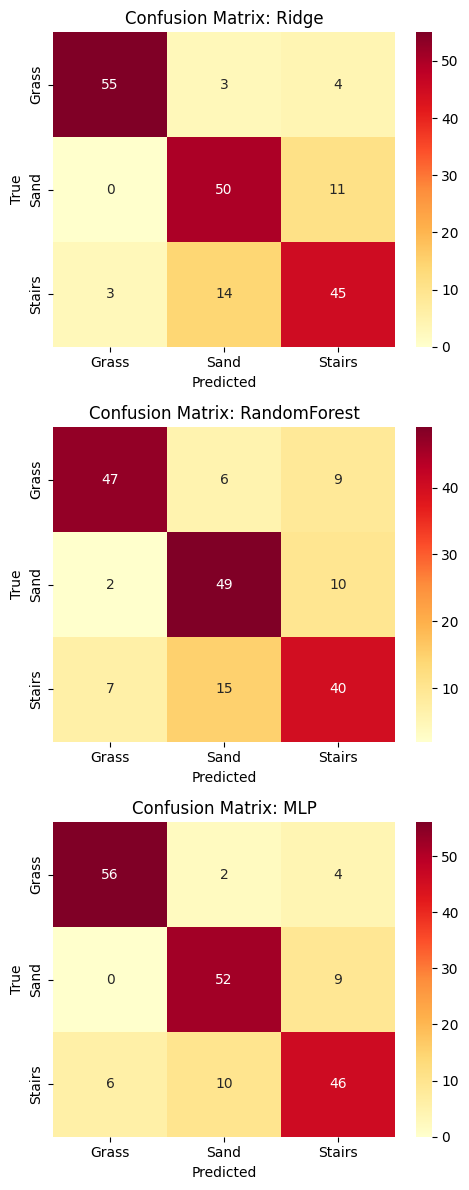

In [22]:
# Plot Confusion Matrices
plt.figure(figsize=(5, 12))
for i, (model_name, cm) in enumerate(conf_matrices.items()):
    plt.subplot(3, 1, i+1)
    sns.heatmap(cm, cmap='YlOrRd', annot=True, xticklabels=class_labels.values(), yticklabels=class_labels.values())
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")

plt.tight_layout()
plt.show()

Nested cross-validation provides a realistic and unbiased estimate of model performance on unseen data. It is useful to ensure that hyperparameters are selected without data leakage. The results of this evaluation technique suggest that the prediction accuracies on the test sets are generally consistent across folds for each model that we trained. Thus, the models can be considered stable, as they seem to generalize well and do not overfit.

## Discussion of the results

#### Model performances, limitations and possible improvements

From the results, the MLP (Multi-Layer Perceptron) classifier achieves the highest mean accuracy (0.8324), outperforming both the Ridge classifier (0.8108) and the Random Forest (0.7351). MLP's superior performance is likely due to its ability to model complex, non-linear relationships in the data.
The Ridge classifier also performed well, suggesting that the dataset may have some linear separability, but it was slightly outperformed by MLP. 

On the other hand, we can identify some limitations, like the small dataset. If the dataset is small, the results might not generalize well to new images. The chosen feature representation might also pose issues. As seen, the Random Forest performed poorly, which may indicate that the limited number of features or the feature selection process is not optimal for this model. Although we extracted first-order and GLCM texture features, they may not fully capture the differences between grass, sand, and stairs. More advanced and informative feature extraction techniques (obtained through deep learning-based methods) could enhance performance. 

In addition, there are other possible ways to improve the results. While we used grid search for hyperparameter optimization, finer and more optimized tuning or a broader search space might help find better hyperparameters more efficiently. Then, it should also be taken into account that some features do not contribute much to classification accuracy. An additional feature selection step could be applied to keep only the most relevant features. Last but not least, expanding the dataset with more image samples for training would improve generalization abilities and discriminative power, reducing overfitting.